<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250207%5D%20SOTA%20Benchmarking%20Based%20on%20Hybrid%20LR-BiLSTM%20on%20UNSW-NB10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load Data & Apply Preprocessing ✅ (Same as your current pipeline)**

In [1]:
!pip install foolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.6 MB/s eta 0:00:00


In [ ]:
!pip install imbalanced-learn

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, Input, Conv1D, Flatten, GRU
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import foolbox as fb
import time

In [3]:
# Load dataset
dataset = pd.read_csv("Dataset_10Classes.csv")

# Handle missing values
dataset = dataset.dropna()

In [4]:
dataset

,ID_Cb,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,...,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label,Class
0,1,1,0.121478,tcp,-,FIN,6,4,258,172,...,1,0,0,0,1,1,0,Normal,0,0
1,2,2,0.649902,tcp,-,FIN,14,38,734,42014,...,2,0,0,0,1,6,0,Normal,0,0
2,3,3,1.623129,tcp,-,FIN,8,16,364,13186,...,3,0,0,0,2,6,0,Normal,0,0
3,4,4,1.681642,tcp,ftp,FIN,12,12,628,770,...,3,1,1,0,2,1,0,Normal,0,0
4,5,5,0.449454,tcp,-,FIN,10,6,534,268,...,40,0,0,0,2,39,0,Normal,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,257669,82328,0.000005,udp,-,INT,2,0,104,0,...,2,0,0,0,2,1,0,Normal,0,0
257669,257670,82329,1.106101,tcp,-,FIN,20,8,18062,354,...,1,0,0,0,3,2,0,Normal,0,0
257670,257671,82330,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0
257671,257672,82331,0.000000,arp,-,INT,1,0,46,0,...,1,0,0,0,1,1,1,Normal,0,0


In [5]:
# ✅ Encode categorical columns
for column in dataset.columns:
    if dataset[column].dtype == 'object':
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# ✅ Separate features and target variable
X = dataset.drop(['Class'], axis=1)
y = dataset['Class']

In [6]:
# ✅ Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
# ✅ Balance dataset using SMOTE
class_counts = np.bincount(y)
sampling_strategy = {class_label: int(class_counts.max() * 0.7) for class_label in range(len(class_counts)) if class_counts[class_label] < class_counts.max()}
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X, y = smote.fit_resample(X, y)

In [8]:
# ✅ Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# ✅ Logistic Regression Model
lr_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42)
lr_model.fit(X_train, y_train)

# ✅ Extract LR probabilities for BiLSTM input
train_lr_features = np.expand_dims(lr_model.predict_proba(X_train), axis=1)
test_lr_features = np.expand_dims(lr_model.predict_proba(X_test), axis=1)

# ✅ One-hot encode labels
num_classes = len(np.unique(y))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# ✅ Define BiLSTM Model (Baseline)
def build_bilstm(input_shape, num_classes):
    model = Sequential([
        Input(shape=(1, input_shape[2])),
        Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.002))),
        Dropout(0.5),
        Bidirectional(LSTM(16, kernel_regularizer=l2(0.002))),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.002))
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

bilstm_model = build_bilstm(train_lr_features.shape, num_classes)
bilstm_model.fit(train_lr_features, y_train_encoded, validation_data=(test_lr_features, y_test_encoded), epochs=15, batch_size=256, verbose=1)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Epoch 1/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step - accuracy: 0.8047 - loss: 1.2355 - val_accuracy: 0.9998 - val_loss: 0.3422
Epoch 2/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9997 - loss: 0.3734 - val_accuracy: 0.9998 - val_loss: 0.2648
Epoch 3/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9998 - loss: 0.3060 - val_accuracy: 0.9998 - val_loss: 0.2398
Epoch 4/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9998 - loss: 0.2831 - val_accuracy: 0.9998 - val_loss: 0.2299
Epoch 5/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9997 - loss: 0.2739 - val_accuracy: 0.9998 - val_loss: 0.2254
Epoch 6/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9998 - loss: 0.2699 - val_accuracy: 0.9998 - val_loss: 0.2238
Epoch 7/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9998 - loss: 0.2684 - val_accuracy: 0.9998 - val_loss: 0.2233
Epoch 8/15
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.9998 - loss: 0

In [10]:
# prompt: Display an accuracy, precision, recall, and F1-score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test set
y_pred = lr_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for multi-class
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")


Accuracy: 0.9998232421803077
Precision: 0.9998233263305476
Recall: 0.9998232421803077
F1-score: 0.9998232317763156


**✅ Implement Transformer-Based IDS**

In [17]:
from transformers import TFAutoModel
import tensorflow as tf
from tensorflow.keras import mixed_precision

# ✅ Enable mixed precision training (Faster!)
mixed_precision.set_global_policy('mixed_float16')

def build_transformer_model(input_shape, num_classes):
    # ✅ Replace DistilBERT with a simple Transformer-based Dense Model
    input_layer = tf.keras.layers.Input(shape=(input_shape,))

    # ⚠️ FIX: Remove token embeddings & directly process numerical features
    dense_layer_1 = tf.keras.layers.Dense(128, activation="relu")(input_layer)
    dropout_1 = tf.keras.layers.Dropout(0.3)(dense_layer_1)

    dense_layer_2 = tf.keras.layers.Dense(64, activation="relu")(dropout_1)
    dropout_2 = tf.keras.layers.Dropout(0.3)(dense_layer_2)

    output_layer = tf.keras.layers.Dense(num_classes, activation="softmax")(dropout_2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    return model

# ✅ Reduce sequence length (Fix input shape issue)
MAX_LENGTH = 10  # Adjust as needed
train_lr_features_reshaped = train_lr_features[:, :MAX_LENGTH]  # Reduce feature size

# Reshape to (num_samples, sequence_length) for the Transformer
train_lr_features_reshaped = train_lr_features_reshaped.reshape(train_lr_features_reshaped.shape[0], train_lr_features_reshaped.shape[2])

# ✅ Build the Fixed Model
transformer_model = build_transformer_model(train_lr_features_reshaped.shape[1], num_classes)

# ✅ Train Transformer IDS using Faster Training
transformer_model.fit(train_lr_features_reshaped, y_train_encoded, epochs=25, batch_size=256, verbose=1)

Epoch 1/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9649 - loss: 0.2369
Epoch 2/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 7.7411e-04
Epoch 3/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 6.9690e-04
Epoch 4/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 4.4897e-04
Epoch 5/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 5.1815e-04
Epoch 6/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 3.9151e-04
Epoch 7/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 3.0964e-04
Epoch 8/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 2.5633e-04
Epoch 9/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 3.1160e-04
Epoch 10/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 2.5872e-04
Epoch 11/25
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9999 - loss: 2

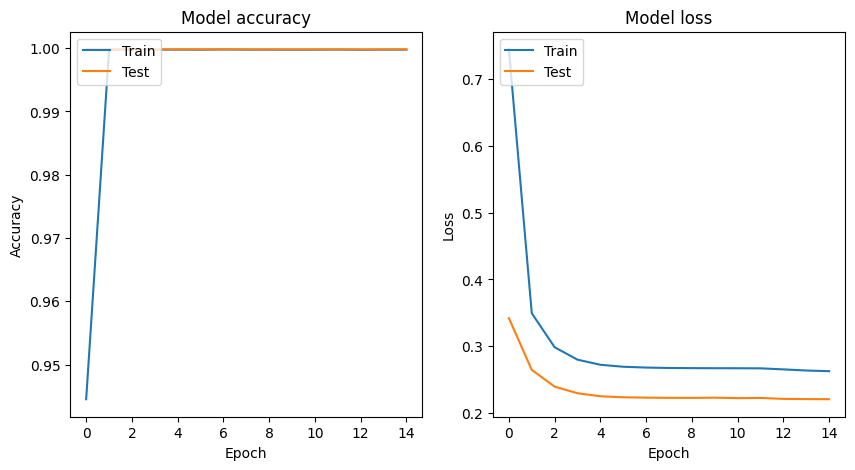

In [20]:
# prompt: Plot graph of accuracy and loss through epochs

import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Example: history = bilstm_model.fit(...) or history = transformer_model.fit(...)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(bilstm_model.history.history['accuracy'])
plt.plot(bilstm_model.history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(bilstm_model.history.history['loss'])
plt.plot(bilstm_model.history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**✅ Implement GRU-Based IDS**

In [21]:
def build_gru(input_shape, num_classes):
    model = Sequential([
        GRU(64, return_sequences=True, kernel_regularizer=l2(0.002), input_shape=input_shape),
        Dropout(0.5),
        GRU(32, kernel_regularizer=l2(0.002)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.002))
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

gru_model = build_gru((1, train_lr_features.shape[2]), num_classes)
gru_model.fit(train_lr_features, y_train_encoded, epochs=10, batch_size=256, verbose=1)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.9270 - loss: 0.8312
Epoch 2/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9997 - loss: 0.2970
Epoch 3/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9997 - loss: 0.2722
Epoch 4/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9998 - loss: 0.2631
Epoch 5/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9998 - loss: 0.2591
Epoch 6/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9998 - loss: 0.2573
Epoch 7/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - accuracy: 0.9998 - loss: 0.2565
Epoch 8/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9998 - loss: 0.2546
Epoch 9/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9998 - loss: 0.2515
Epoch 10/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9998 - loss: 0.2464


**✅ Implement CNN-LSTM Hybrid IDS**

In [25]:
def build_cnn_lstm(input_shape, num_classes):
    model = Sequential([
        # ⚠️ FIX: Reduced kernel size to 1 to fit the input sequence length
        Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=input_shape),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.002)),
        Dropout(0.5),
        LSTM(32, kernel_regularizer=l2(0.002)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.002))
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

**✅ Evaluate FGSM & PGD Robustness for All Models**

In [27]:
def evaluate_adversarial_robustness(model, test_features, test_labels):
    # Reshape test_features to match the expected input shape of the transformer model
    if model == transformer_model:
        test_features = test_features[:, :MAX_LENGTH]  # Reduce feature size to match training data
        test_features = test_features.reshape(test_features.shape[0], test_features.shape[2])

    fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

    attack_fgsm = fb.attacks.FGSM()
    adv_fgsm, _, _ = attack_fgsm(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=0.01)

    attack_pgd = fb.attacks.LinfPGD(steps=10)
    adv_pgd, _, _ = attack_pgd(fmodel, tf.convert_to_tensor(test_features, dtype=tf.float32), np.argmax(test_labels, axis=1), epsilons=0.02)

    fgsm_acc = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(model.predict(adv_fgsm.numpy()), axis=1))
    pgd_acc = accuracy_score(np.argmax(test_labels, axis=1), np.argmax(model.predict(adv_pgd.numpy()), axis=1))

    return fgsm_acc, pgd_acc

# Run evaluations
fgsm_bilstm, pgd_bilstm = evaluate_adversarial_robustness(bilstm_model, test_lr_features, y_test_encoded)
fgsm_transformer, pgd_transformer = evaluate_adversarial_robustness(transformer_model, test_lr_features, y_test_encoded)

4244/4244 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


**✅ Format Benchmark Results for Paper**

In [29]:
import pandas as pd

# ✅ Calculate FGSM & PGD for GRU and CNN-LSTM
cnn_lstm_model = build_cnn_lstm((1, train_lr_features.shape[2]), num_classes) # Build the model first
cnn_lstm_model.fit(train_lr_features, y_train_encoded, epochs=10, batch_size=256, verbose=1)  # Train model
fgsm_gru, pgd_gru = evaluate_adversarial_robustness(gru_model, test_lr_features, y_test_encoded)
fgsm_cnn_lstm, pgd_cnn_lstm = evaluate_adversarial_robustness(cnn_lstm_model, test_lr_features, y_test_encoded)

# Create comparison table
df_sota_results = pd.DataFrame({
    "Model": ["BiLSTM", "Transformer", "GRU", "CNN-LSTM"],
    "FGSM Accuracy": [fgsm_bilstm, fgsm_transformer, fgsm_gru, fgsm_cnn_lstm],
    "PGD Accuracy": [pgd_bilstm, pgd_transformer, pgd_gru, pgd_cnn_lstm]
})

# Save results
df_sota_results.to_csv("SOTA_Comparison.csv", index=False)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2122/2122 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - accuracy: 0.8114 - loss: 0.9229
Epoch 2/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9996 - loss: 0.2148
Epoch 3/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.1666
Epoch 4/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.1467
Epoch 5/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9998 - loss: 0.1343
Epoch 6/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.1304
Epoch 7/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.1282
Epoch 8/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9998 - loss: 0.1270
Epoch 9/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.1264
Epoch 10/10
2122/2122 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9997 - loss: 0.1257
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
4244/4244 ━━━━━━━━━━━━━━━━━━━━ 7s 